In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
Dataset_path="exam"

IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=42



In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

full_val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
train_size=len(train_ds)
val_size=len(full_val_ds)//2
test_size=len(full_val_ds)-val_size

valid_ds=full_val_ds.take(val_size)
test_ds=full_val_ds.skip(val_size)

print("Training set size:",train_size,"batches")
print("validation set size:",val_size,"batches")
print("Test set size:",test_size,"batches")


Found 1000 files belonging to 2 classes.
Using 700 files for training.
Found 1000 files belonging to 2 classes.
Using 300 files for validation.
Training set size: 22 batches
validation set size: 5 batches
Test set size: 5 batches


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [6]:
model= Sequential([
    Conv2D(32, (3,3), activation='relu',input_shape=(224,224,3), padding='same', name='conv1'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same', name='conv2'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [7]:
EPOCHS=1
history=model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS)

22/22 [==============================] - 59s 3s/step - loss: 205.8930 - accuracy: 0.5086 - val_loss: 0.7004 - val_accuracy: 0.4750


In [8]:
def preprocess(image):
    image=tf.image.resize(image,(224,224))
    image=tf.cast(image,tf.float32)/255.0
    return image
preprocessed_ds=train_ds.map(lambda img, label: (preprocess(img),label)).batch(1)

In [9]:
image,label=next(iter(preprocessed_ds))

In [10]:
for images,label in train_ds.take(1):
    single_image = images[0].numpy()  # Take the first image and convert to NumPy
    break

In [11]:
single_image.shape


(224, 224, 3)

In [12]:
model_wo_softmax = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output  # Output of the last layer before softmax
)
model_wo_softmax.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 128)       73856 

In [13]:
image_np = single_image  # only works in eager mode
image_np = np.expand_dims(image_np, axis=0)  # add batch dim if missing
image_np.shape

(1, 224, 224, 3)

In [ ]:
import innvestigate
import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()
analyzer = innvestigate.create_analyzer("lrp.epsilon", model_wo_softmax)

analysis = analyzer.analyze(image_np)

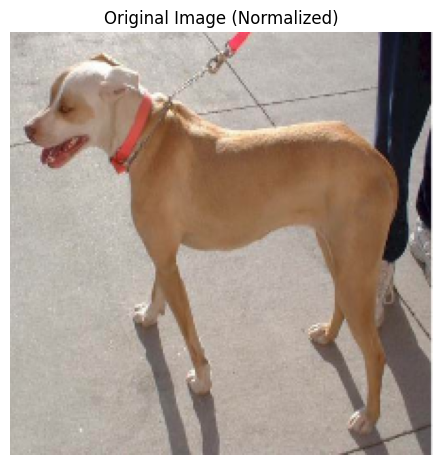

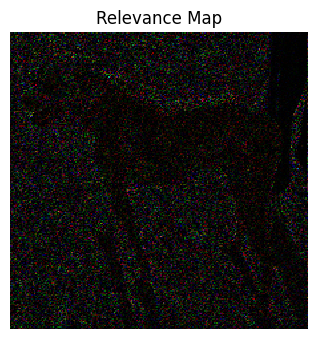

In [26]:
analysis_normalized = analysis[0] / max(abs(analysis[0].max()), abs(analysis[0].min()))

# Plot the original image and the relevance map
plt.figure(figsize=(12, 6))

img = image_np[0]

# If values are small (like from model output), normalize to 0–1
img_min = img.min()
img_max = img.max()

if img_max - img_min > 0:
    img = (img - img_min) / (img_max - img_min)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Original Image (Normalized)")
plt.show()


# Relevance Map
plt.subplot(1, 2, 2)
plt.title("Relevance Map")
plt.imshow(analysis_normalized, cmap="seismic", interpolation="nearest")
plt.axis("off")
plt.tight_layout()
plt.show()